In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#multimodele finale entrainé sur le train complet

chargement du train fusioné CNN BERT à la volée, pour une question de mémoire RAM, il ne nous a pas été possible d'enregistrer un dataset tensorflow, nous le recréons à la volée.
Pour le trtestain et le val, nous avons pu enregistrer sur le drive.

In [2]:
import os
import tensorflow as tf

save_dir_bert = '/content/drive/MyDrive/formation Datascientest/RVL-CDIP/BERT2/'
train_dataset_bert_path = os.path.join(save_dir_bert, 'train_tf_dataset')
train_dataset_bert = tf.data.Dataset.load(train_dataset_bert_path).prefetch(tf.data.AUTOTUNE)

In [3]:
from tqdm import tqdm

def create_image_id_mapping_bert(dataset):
    dataset_dict = {}
    total = tf.data.experimental.cardinality(dataset).numpy()
    if total == tf.data.experimental.INFINITE_CARDINALITY:
        total = None

    # Ajouter la barre de progression tqdm
    for inputs, label in tqdm(dataset, total=total, desc='Création du mapping image_ID pour BERT'):
        # Les labels sont scalaires, pas de dimension de batch
        image_ID = inputs['image_ID'].numpy().decode('utf-8')
        data = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
        }
        dataset_dict[image_ID] = (data, label)
    return dataset_dict


In [4]:
def merge_datasets(bert_dict, cnn_dict):
    merged_data = []
    for image_ID in bert_dict.keys():
        if image_ID in cnn_dict:
            bert_data, bert_label = bert_dict[image_ID]
            cnn_data, cnn_label = cnn_dict[image_ID]

            # Vérifier que les labels sont identiques
            if bert_label != cnn_label:
                print(f"Avertissement : labels différents pour image_ID {image_ID}")

            merged_inputs = {
                'input_ids': bert_data['input_ids'],
                'attention_mask': bert_data['attention_mask'],
                'image': cnn_data['image'],
                'image_ID': image_ID,
            }
            label = bert_label  # On peut choisir l'un ou l'autre, ils devraient être identiques

            merged_data.append((merged_inputs, label))
    return merged_data


In [5]:
def create_tf_dataset_from_merged_data(merged_data):
    def generator():
        for inputs, label in merged_data:
            yield inputs, label

    output_signature = (
        {
            'input_ids': tf.TensorSpec(shape=(512,), dtype=tf.int32),
            'attention_mask': tf.TensorSpec(shape=(512,), dtype=tf.int32),
            'image': tf.TensorSpec(shape=(224, 224, 1), dtype=tf.float32),
            'image_ID': tf.TensorSpec(shape=(), dtype=tf.string),
        },
        tf.TensorSpec(shape=(), dtype=tf.int64)  # Label en dehors des inputs
    )
    dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    return dataset

In [6]:
import pickle

# Fonction pour sauvegarder le dictionnaire
def save_dataset_dict_pickle(dataset_dict, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(dataset_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Fonction pour charger le dictionnaire
def load_dataset_dict_pickle(filename):
    with open(filename, 'rb') as handle:
        dataset_dict = pickle.load(handle)
    return dataset_dict


nous regroupons les features CNN et BERT dans un même dataset tensorflow.
Les features CNN on été enregistré dans un dictionnaire, sauvé au format pkl

In [7]:
save_dir_merged = '/content/drive/MyDrive/formation Datascientest/RVL-CDIP/merged_datasets/'
train_dataset_cnn_dict_path = os.path.join(save_dir_merged, 'train_dataset_cnn_dict2.pkl')
train_dataset_cnn_dict = load_dataset_dict_pickle(train_dataset_cnn_dict_path)

train_dataset_bert_dict = create_image_id_mapping_bert(train_dataset_bert)
# train_dataset_bert_dict_path = os.path.join(save_dir_merged, 'train_dataset_bert_dict2.pkl')
# save_dataset_dict_pickle(train_dataset_bert_dict, train_dataset_bert_dict_path)
# Fusion des datasets
merged_train_data = merge_datasets(train_dataset_bert_dict, train_dataset_cnn_dict)

# Création du dataset final
final_train_dataset = create_tf_dataset_from_merged_data(merged_train_data)



Création du mapping image_ID pour BERT: 100%|██████████| 320000/320000 [01:38<00:00, 3254.86it/s]


Modéliisation multimodel BERT CNN

In [ ]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Lambda
import os
from keras.saving import register_keras_serializable
import numpy as np

# ------------------------------------------------------------------------------
# 1. Configuration Initiale
# ------------------------------------------------------------------------------
print("Num GPUs Available (TensorFlow): ", len(tf.config.list_physical_devices('GPU')))

# Chemins des modèles et des datasets
drive_model_BERT_dir = '/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/saved_BERTmodel_tensorflow_01/'
drive_model_CNN_dir = '/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/CNN/saved_modelcnn.keras'
save_dir_merged = '/content/drive/MyDrive/formation Datascientest/RVL-CDIP/merged_datasets/'
batch_size = 32

name_preprocessed_train = 'merged_train_dataset'
name_preprocessed_val = 'merged_val_dataset'
name_preprocessed_test = 'merged_test_dataset'

# ------------------------------------------------------------------------------
# 2. Chargement des Modèles
# ------------------------------------------------------------------------------
# Charger le modèle CNN
cnn_model = tf.keras.models.load_model(drive_model_CNN_dir)
# cnn_model.trainable = False  # Geler les poids du CNN

# Charger le modèle BERT pour la classification de séquences
bert_model = TFBertForSequenceClassification.from_pretrained(drive_model_BERT_dir)
# bert_model.trainable = False  # Geler les poids de BERT

# ------------------------------------------------------------------------------
# 3. Préparation des Extracteurs de Caractéristiques
# ------------------------------------------------------------------------------
# a. Extracteur de Caractéristiques pour le CNN
# ------------------------------------------------------------------------------
# Identifier la couche de caractéristiques dans le CNN
# Dans votre résumé de modèle, la couche 'dense' produit des caractéristiques de taille 512
feature_layer_name = 'dense'  # À adapter si votre couche de caractéristiques a un autre nom

# Créer un modèle d'extraction de caractéristiques à partir du CNN en excluant l'InputLayer
cnn_feature_extractor = models.Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer(feature_layer_name).output
)
cnn_feature_extractor.trainable = False  # S'assurer que les poids restent gelés

# b. Extracteur de Caractéristiques pour BERT
# ------------------------------------------------------------------------------
# `TFBertForSequenceClassification` inclut une couche de classification. Nous allons utiliser les logits comme caractéristiques textuelles.
# Si vous souhaitez utiliser une autre représentation (comme `pooler_output`), vous pouvez ajuster cela ici.

# Note : `TFBertForSequenceClassification` a déjà une couche de classification intégrée,
# donc nous allons extraire les logits directement.

# ------------------------------------------------------------------------------
# 4. Chargement et Préparation des Datasets
# ------------------------------------------------------------------------------
# Charger les datasets
# train_dataset_path = os.path.join(save_dir_merged, name_preprocessed_train)
val_dataset_path = os.path.join(save_dir_merged, name_preprocessed_val)
test_dataset_path = os.path.join(save_dir_merged, name_preprocessed_test)

# Charger les datasets avec prefetch pour optimiser les performances
# train_dataset = tf.data.Dataset.load(train_dataset_path).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.load(val_dataset_path).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.load(test_dataset_path).prefetch(tf.data.AUTOTUNE)

# Fonction pour supprimer 'image_ID' des inputs
def remove_image_id(dataset):
    def map_fn(inputs, labels):
        # Exclure 'image_ID'
        inputs_without_image_id = {key: value for key, value in inputs.items() if key != 'image_ID'}
        return inputs_without_image_id, labels
    return dataset.map(map_fn)

# Appliquer la suppression de 'image_ID' sur tous les datasets
train_tf_dataset = remove_image_id(final_train_dataset)
val_tf_dataset = remove_image_id(val_dataset)
test_tf_dataset = remove_image_id(test_dataset)

# Fonction pour préparer les datasets
def prepare_dataset(dataset, already_batched=False):
    def map_fn(inputs, labels):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        image = inputs['image']
        return {'image': image, 'input_ids': input_ids, 'attention_mask': attention_mask}, labels

    if already_batched:
        return dataset.map(map_fn).prefetch(tf.data.AUTOTUNE)
    else:
        return dataset.map(map_fn).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Définir si le dataset est déjà batché en fonction de l'inspection précédente
# Si les formes des entrées incluent le batch_size (première dimension), définissez `already_batched=True`
# Sinon, définissez `already_batched=False`
# Basé sur l'inspection précédente, supposons que les datasets ne sont pas batchés
already_batched = False  # Changez en True si le dataset est déjà batché

# Préparer les datasets
train_tf_dataset_prepared = prepare_dataset(train_tf_dataset, already_batched=already_batched)
val_tf_dataset_prepared = prepare_dataset(val_tf_dataset, already_batched=already_batched)
test_tf_dataset_prepared = prepare_dataset(test_tf_dataset, already_batched=already_batched)

# ------------------------------------------------------------------------------
# 5. Définition de la Couche Personnalisée pour BERT
# ------------------------------------------------------------------------------
@register_keras_serializable()
class TFBertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(TFBertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs, training=False):
        input_ids = inputs[0]
        attention_mask = inputs[1]
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask, training=training)
        return outputs.logits

    def get_config(self):
        config = super(TFBertLayer, self).get_config()
        config['bert_model'] = drive_model_BERT_dir
        return config

    @classmethod
    def from_config(cls, config):
        bert_model = TFBertForSequenceClassification.from_pretrained(config['bert_model'])
        return cls(bert_model=bert_model, **{k: v for k, v in config.items() if k != 'bert_model'})

# ------------------------------------------------------------------------------
# 6. Construction du Modèle Multimodal
# ------------------------------------------------------------------------------
# Définir les entrées du modèle
image_input = tf.keras.Input(shape=(224, 224, 1), name='image')  # Entrée pour les images
input_ids = tf.keras.Input(shape=(512,), dtype=tf.int32, name='input_ids')  # Entrée pour les tokens BERT
attention_mask = tf.keras.Input(shape=(512,), dtype=tf.int32, name='attention_mask')  # Entrée pour les masques d'attention BERT

# a. Passer l'image à travers l'extracteur de caractéristiques CNN
cnn_features = cnn_feature_extractor(image_input)  # Sortie: (batch_size, 512)

# b. Passer le texte à travers le modèle BERT via la couche personnalisée
bert_logits = TFBertLayer(bert_model=bert_model, name='bert_logits')([input_ids, attention_mask])  # Sortie: (batch_size, 16)

# c. Combiner les caractéristiques du CNN et les logits de BERT
combined_features = layers.Concatenate(name='concatenated_features')([cnn_features, bert_logits])  # Sortie: (batch_size, 512 + 16 = 528)

# d. Ajouter des couches denses pour la classification finale
x = layers.Dense(256, activation='relu', name='dense_1')(combined_features)
x = layers.Dropout(0.5, name='dropout')(x)
output = layers.Dense(16, activation='softmax', name='output')(x)  # 16 classes pour RVL-CDIP

# e. Construire le modèle final
multimodal_model = models.Model(inputs=[input_ids, image_input,attention_mask ], outputs=output)

# ------------------------------------------------------------------------------
# 7. Compilation du Modèle
# ------------------------------------------------------------------------------
multimodal_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

# Afficher le résumé du modèle
multimodal_model.summary()

# ------------------------------------------------------------------------------
# 8. Entraînement du Modèle Multimodal
# ------------------------------------------------------------------------------
# Définir les callbacks
# permet de stopper l'entrainement
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#permet de diminuer le learning rate d'un facteur 10 en cas de plateau
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
#enregistrment du modèle au fur et à mesure, en cas de plantage colab
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/models/best_multimodal_model3.keras',
    monitor='val_loss',
    save_best_only=True
)

# Entraîner le modèle
history = multimodal_model.fit(
    train_tf_dataset_prepared,
    validation_data=val_tf_dataset_prepared,
    epochs=100,  # Commencer avec un nombre raisonnable d'époques
    callbacks=[early_stopping, lr_scheduler, checkpoint]
)


# ------------------------------------------------------------------------------
# 9. Sauvegarde du Modèle Entraîné
# ------------------------------------------------------------------------------
# multimodal_model.save('/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/models/multimodal_model_complet4.keras')
multimodal_model.save('/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/models/multimodal_model_complet3.keras', save_format='keras')
history_path = '/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/models/history/training_multi_history3.npy'
# Sauvegarder l'historique d'entraînement
np.save(history_path, history.history)
# ------------------------------------------------------------------------------
# 10. Évaluation du Modèle sur les Données de Test
# ------------------------------------------------------------------------------
# test_loss, test_acc = multimodal_model.evaluate(test_tf_dataset_prepared)
# print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# # Évaluation détaillée avec rapport de classification et matrice de confusion
# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np

# # Prédictions
# predictions = multimodal_model.predict(test_tf_dataset_prepared)
# y_pred = np.argmax(predictions, axis=1)

# # Extraction des vraies labels
# y_true = []
# for _, labels in test_tf_dataset_prepared:
#     y_true.extend(labels.numpy())

# # Afficher le rapport de classification et la matrice de confusion
# print(classification_report(y_true, y_pred))
# print(confusion_matrix(y_true, y_pred))


Num GPUs Available (TensorFlow):  1


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 66 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/saved_BERTmodel_tensorflow_01/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ids (InputLayer)    │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 512)            │     27,560,286 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_logits (TFBertLayer) │ (None, 16)             │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenated_features     │ (None, 528)            │              0 │ functional[0][0],      │
│ (Concatenate)             │                        │                │ bert_logits[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        135,424 │ concatenated_features… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 16)             │          4,112 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 27,699,822 (105.67 MB)

 Trainable params: 139,536 (545.06 KB)

 Non-trainable params: 27,560,286 (105.13 MB)

Epoch 1/100
  10000/Unknown 864s 83ms/step - accuracy: 0.8502 - loss: 0.5176

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 964s 93ms/step - accuracy: 0.8502 - loss: 0.5176 - val_accuracy: 0.8653 - val_loss: 0.4609 - learning_rate: 0.0010
Epoch 2/100
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 916s 92ms/step - accuracy: 0.8694 - loss: 0.4520 - val_accuracy: 0.8663 - val_loss: 0.4541 - learning_rate: 0.0010
Epoch 3/100
 7708/10000 ━━━━━━━━━━━━━━━━━━━━ 3:09 83ms/step - accuracy: 0.8722 - loss: 0.4412

Résultat du multimodel

In [ ]:
import numpy as np
history_path = '/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/models/history/training_multi_history3.npy'
np.save(history_path, history.history)

Some layers from the model checkpoint at /content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/saved_BERTmodel_tensorflow_01/ were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/saved_BERTmodel_tensorflow_01/.
If your task is similar to the task the model of the checkpoint was tra

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 119s 84ms/step - accuracy: 0.8781 - loss: 0.4235
Test Loss: 0.4338017702102661, Test Accuracy: 0.8753218650817871
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 103s 76ms/step


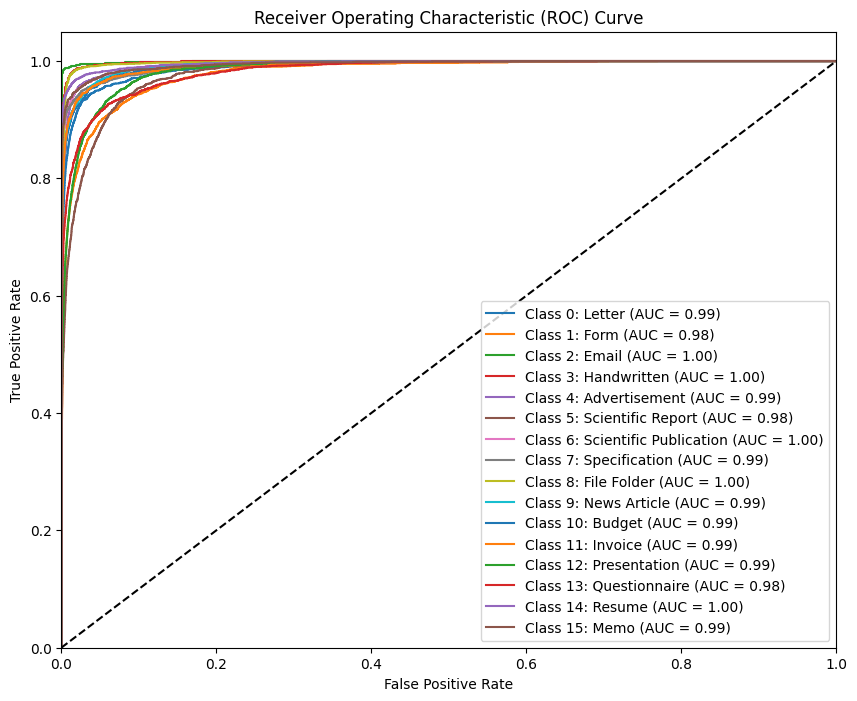

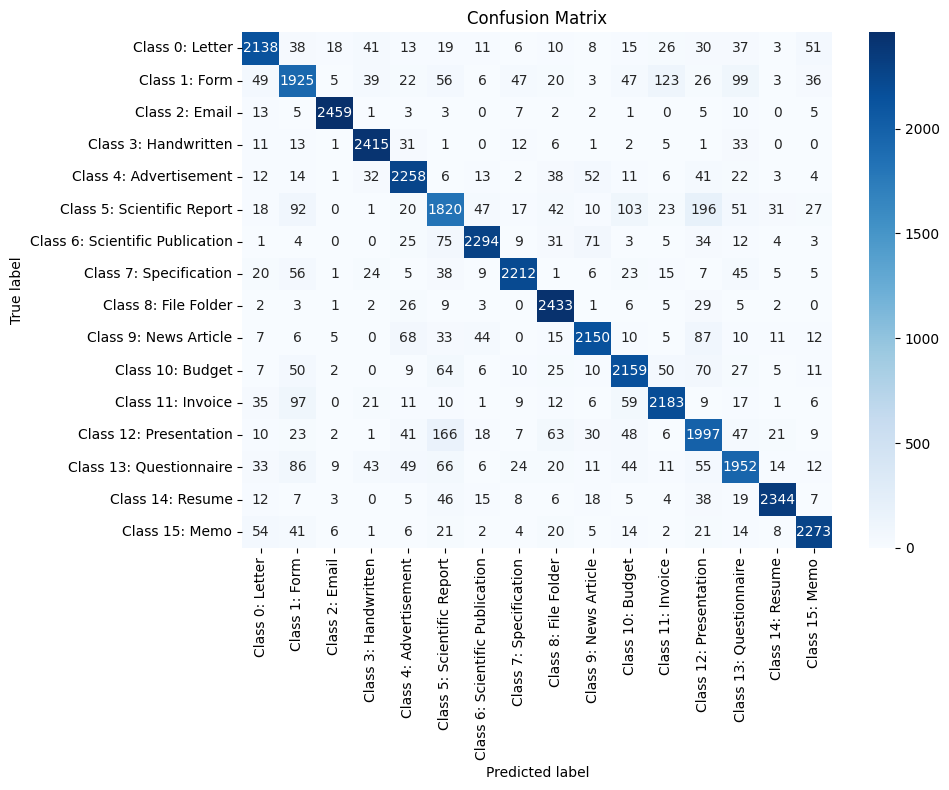

Classification Report (Console Output):
                                 precision    recall  f1-score   support

                Class 0: Letter       0.88      0.87      0.88      2464
                  Class 1: Form       0.78      0.77      0.78      2506
                 Class 2: Email       0.98      0.98      0.98      2516
           Class 3: Handwritten       0.92      0.95      0.94      2532
         Class 4: Advertisement       0.87      0.90      0.88      2515
     Class 5: Scientific Report       0.75      0.73      0.74      2498
Class 6: Scientific Publication       0.93      0.89      0.91      2571
         Class 7: Specification       0.93      0.89      0.91      2472
           Class 8: File Folder       0.89      0.96      0.92      2527
          Class 9: News Article       0.90      0.87      0.89      2463
               Class 10: Budget       0.85      0.86      0.85      2505
              Class 11: Invoice       0.88      0.88      0.88      2477
         C

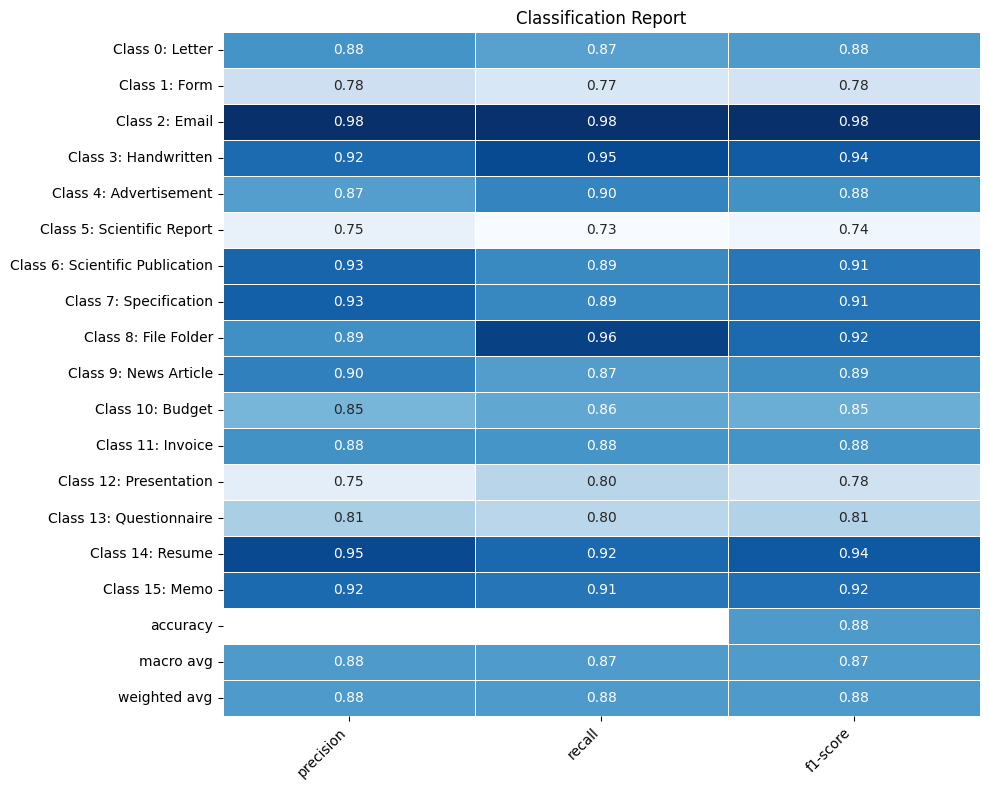

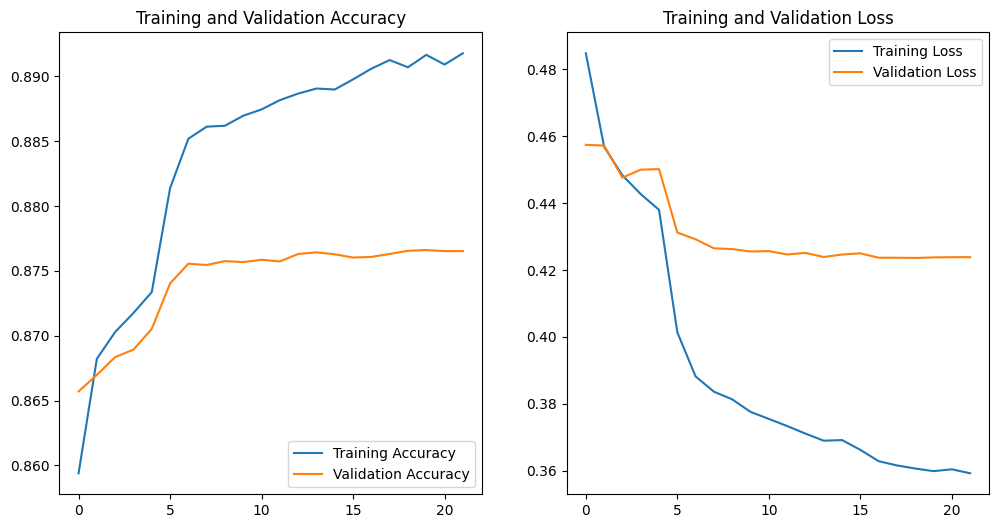

In [ ]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Lambda
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
import json
from keras.models import load_model

#-------------------------------------------------------------------------------
# Paramétrage de lancement
#-------------------------------------------------------------------------------
# Chemin vers le modèle sauvegardé et le dataset de test
model_path = "/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/models/multimodal_model_complet3.keras"
test_dataset_tf_path = "/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/models/merged_test_dataset_final"
output_file_path = "/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/models/classification_multi_report3.json"
history_path = '/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/models/history/training_multi_history3.npy'
#-------------------------------------------------------------------------------
# Paramétrage de lancement
#-------------------------------------------------------------------------------

# Charger le modèle
# model = tf.keras.models.load_model(model_path)
# model = tf.keras.models.load_model(model_path2)
# model = load_model(model_path, custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})
model = load_model(model_path, custom_objects={'TFBertLayer': TFBertLayer})
# Charger le dataset TensorFlow de test
test_dataset_tf = tf.data.Dataset.load(test_dataset_tf_path)

# Évaluer le modèle
test_loss, test_acc = model.evaluate(test_dataset_tf)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Faire les prédictions sur le dataset de test
y_true = []  # Pour stocker les vraies étiquettes
y_pred_probs = []  # Pour stocker les probabilités prédites pour chaque classe

# Prédictions
predictions = model.predict(test_tf_dataset_prepared)
y_pred_probs = predictions

# Extraction des vraies labels
for _, labels in test_tf_dataset_prepared:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Convertir les étiquettes en format one-hot encoding (nécessaire pour ROC multi-classes)
n_classes = 16  # Le nombre de classes
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Calculer fprs, tprs, aucs pour chaque classe
fprs = {}
tprs = {}
aucs = {}
for i in range(n_classes):
    fprs[i], tprs[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    aucs[i] = auc(fprs[i], tprs[i])

# Les noms des labels associés aux classes avec le numéro
class_labels = ['Class 0: Letter', 'Class 1: Form', 'Class 2: Email', 'Class 3: Handwritten',
                'Class 4: Advertisement', 'Class 5: Scientific Report', 'Class 6: Scientific Publication',
                'Class 7: Specification', 'Class 8: File Folder', 'Class 9: News Article',
                'Class 10: Budget', 'Class 11: Invoice', 'Class 12: Presentation',
                'Class 13: Questionnaire', 'Class 14: Resume', 'Class 15: Memo']

# Tracer la courbe ROC avec les noms des labels et numéros de classes
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, roc_auc) in enumerate(zip(fprs.values(), tprs.values(), aucs.values())):
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# **Matrice de confusion**
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convertir les probabilités en classes
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# **Rapport de classification sous forme de tableau**
# 1. **Afficher le rapport de classification dans la console (sans `output_dict`)**
report_console = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Classification Report (Console Output):")
print(report_console)

# 2. **Sauvegarder le rapport de classification dans un fichier JSON ou CSV avec `output_dict=True`**
report_dict = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)

# Sauvegarder en JSON
with open(output_file_path, 'w') as f:
    json.dump(report_dict, f, indent=4)

print(f"Classification report saved to {output_file_path}")

# 3. **Convertir le rapport de classification en DataFrame pour l'afficher
report_df = pd.DataFrame(report_dict).transpose()

# Supprimer les colonnes 'precision' et 'recall' pour la ligne 'accuracy'
report_df.loc['accuracy', ['precision', 'recall']] = [None, None]

# Affichage du rapport sous forme de tableau (plot)
plt.figure(figsize=(10, 8))
sns.heatmap(report_df.iloc[:, :-1], annot=True, fmt=".2f", cmap="Blues", cbar=False, linewidths=0.5)
plt.title('Classification Report')
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# **Courbes d'apprentissage (si historique disponible)
try:
    history = np.load(history_path, allow_pickle=True).item()

    plt.figure(figsize=(12, 6))

    # Précision
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Perte
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.savefig('learning_curves.png')
    plt.show()
except FileNotFoundError:
    print("Training history not found, skipping learning curves plot.")